# Import Functions

In [33]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
from skimage.feature import peak_local_max
import h5py

In [2]:
import matplotlib.pylab as pylab

params = {'axes.titlesize':20,
          'xtick.direction': 'in' ,
          'ytick.direction' : 'in',
          'xtick.top' : True,
          'ytick.right' : True,
          'ytick.labelsize':16,
          'xtick.labelsize':16
         }

pylab.rcParams.update(params)

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
#import atomai as aoi
#import kornia as K
import cv2
import scipy
import argparse
import skimage
from skimage.util import random_noise
from skimage import feature
import glob
from scipy import ndimage
import scipy as sp
import random

In [5]:
import warnings
warnings.filterwarnings('ignore') 

In [7]:
torch.cuda.device_count()

1

# Build two type of mask for two training process

## Set the mask function

In [8]:
def mask_function(img,radius=7,center_coordinates=(100,100)):
    image = np.copy(img.squeeze())
    thickness = -1
    color = 100
    image_2 = cv2.circle(image, center_coordinates, radius,color, thickness)
    image_2 = np.array(image_2)
    mask = (image_2==100)
    mask = np.array(mask)

    return mask

## Set a 200x200 image

In [9]:
mean_ = np.zeros([200,200])

## Build Mask 2

### define the original 6 dots mask framework 

In [10]:
mask_0 = mask_function(mean_,radius=12,center_coordinates=(99,162))
mask_1 = mask_function(mean_,radius=12,center_coordinates=(154,130))
mask_2 = mask_function(mean_,radius=12,center_coordinates=(154,68))
mask_3 = mask_function(mean_,radius=12,center_coordinates=(99,36))
mask_4 = mask_function(mean_,radius=12,center_coordinates=(45,68))
mask_5 = mask_function(mean_,radius=12,center_coordinates=(45,130))
# Combine all components together

mask_up_2 = mask_0+mask_1+mask_2+mask_3+mask_4+mask_5

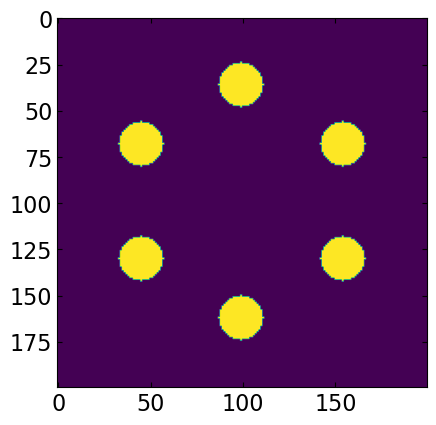

In [11]:
plt.imshow(mask_up_2)

In [12]:
mask_0 = torch.tensor(mask_0)
mask_1 = torch.tensor(mask_1)
mask_2 = torch.tensor(mask_2)
mask_3 = torch.tensor(mask_3)
mask_4 = torch.tensor(mask_4)
mask_5 = torch.tensor(mask_5)

In [13]:
mask_list_2 = [mask_0,mask_1,mask_2,mask_3,mask_4,mask_5]
new_mask_2 = torch.tensor(mask_up_2)

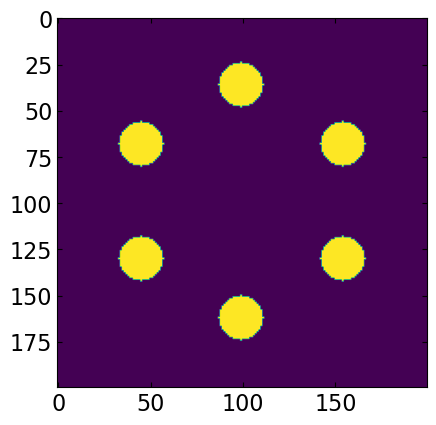

In [16]:
plt.imshow(mask_up_2)

# Loading Data

## data is on zenodo: https://zenodo.org/records/10836435

In [54]:
# Set data direction
data_dir = os.path.abspath("./Extremely_Noisy_4DSTEM_Strain_Mapping_Using_CC_ST_AE_Simulated/polycrystal_output4D.mat")

## Load data function 1 for first training process

## Load data function 2 for second training process

In [18]:
def load_data_4_process2(data_dir, pre_rot, w_bg=0.60):
    
    '''
    
        data_dir: path of the dataset
        label_index: path of the pretrained rotation 
    
    '''
    
    f = h5py.File(data_dir,'r')
    op4d = f['output4D']
    op4d = op4d[:,:,28:228,28:228]
    op4d = np.transpose(op4d, (1, 0, 3, 2))
    op4d = op4d.reshape(-1,200,200)
    f.close()
    
    if w_bg == 0:
        
        noisy_data = op4d*1e5/4
    
    else:
    
        noisy_data = np.zeros([65536,200,200])
        im=np.zeros([200,200])
        counts_per_probe = 1e5
        for i in tqdm(range(65536),leave=True,total=65536):
            test_img = np.copy(op4d[i])
            qx = np.fft.fftfreq( im.shape[0], d = 1)
            qy = np.fft.fftfreq( im.shape[1], d = 1)
            qya, qxa = np.meshgrid(qy, qx)
            qxa = np.fft.fftshift(qxa)
            qya = np.fft.fftshift(qya) 
            qra2 = qxa**2 + qya**2
            im_bg = 1./( 1 + qra2 / 1e-2**2 )
            im_bg = im_bg / np.sum(im_bg) 
            int_comb = test_img * (1 - w_bg) + im_bg * w_bg 
            int_noisy = np.random.poisson(int_comb * counts_per_probe) / counts_per_probe
            int_noisy = int_noisy*1e5/4
            noisy_data[i] = int_noisy
        
    del op4d
    
    noisy_data = noisy_data.reshape(-1,1,200,200)
    angle = np.mod(np.arctan2(
        pre_rot[:,1].reshape(256,256),
        pre_rot[:,0].reshape(256,256)),np.pi/3).reshape(-1)
    
    
    # combine the data and label for test
    whole_data_with_rotation = []
    for i in tqdm(range(noisy_data.shape[0]),leave=True, total=noisy_data.shape[0]):
        whole_data_with_rotation.append([noisy_data[i], angle[i]])
        
    return whole_data_with_rotation

# Autoencoder

In [19]:
def crop_small_square(center_coordinates,radius=50):
    
    center_coordinates = torch.round(center_coordinates)
    
    x_coor = (int(center_coordinates[0]-radius),int(center_coordinates[0]+radius))
    
    y_coor = (int(center_coordinates[1]-radius),int(center_coordinates[1]+radius))

    return x_coor,y_coor

In [20]:
def center_of_mass(img,mask,coef=1.5):
    
    cor_x,cor_y = torch.where(mask!=0)
    mean_mass = torch.mean(img[mask])
    mass = F.relu(img[mask]-coef*mean_mass)
    img_after = torch.clone(img)
    img_after[mask] = mass
    
    sum_mass = torch.sum(mass)
    
    if sum_mass == 0:
        weighted_x = torch.sum(cor_x)/len(cor_x)
        weighted_y = torch.sum(cor_y)/len(cor_y)
    else:
        weighted_x = torch.sum(cor_x*mass)/sum_mass
    
        weighted_y = torch.sum(cor_y*mass)/sum_mass
#    plt.figure()
#    plt.imshow(img_after.detach().numpy(),clim=[0,1])
#    plt.figure()
#    plt.plot(weighted_y,weighted_x,'r.')
    return weighted_x,weighted_y

In [21]:
# image: batch input with affine transformation
# mask: the mask added on the diffraction partten
# batch_size: batch of the image
# theta: the batch affine transformation parameter
def revise_size_on_affine_gpu(image, 
                              mask_list, 
                              batch_size, 
                              theta,
                              device,
                              adj_para=None,
                              radius=12,
                              coef=2,
                              pare_reverse=False):
    
#    img0 = np.zeros([image.shape[-1],image.shape[-1]])
    # Add another mask dealing with the diffraction pattern only
    np_img = np.zeros([radius*2,radius*2])
    dot_size = int(4*image.shape[-1]/200)
    small_square_mask = mask_function(np_img,radius=dot_size,center_coordinates=(radius,radius))
    small_square_mask = torch.tensor(small_square_mask,dtype=torch.bool).to(device)

    img = torch.clone(image).to(device)
#    print(img.shape)
    identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(batch_size,1,1).to(device)
    new_theta = torch.cat((theta,identity),axis=1).to(device)
    inver_theta = torch.linalg.inv(new_theta)[:,0:2].to(device)
#    print(theta.shape)
##    print(inver_theta.shape)
#    print('....')
    for j, mask in enumerate(mask_list):
        if mask.shape[0]!= batch_size:
            mask_ = mask.squeeze().unsqueeze(0).unsqueeze(1).repeat(batch_size,1,1,1).to(device)
        else:
            mask_ = mask.reshape(batch_size,1,mask.shape[-2],mask.shape[-1]).to(device)
        
#        print(mask_.shape)
#        mask_ = torch.tensor(mask,dtype=torch.float,requires_grad=True).squeeze().unsqueeze(0).unsqueeze(1).repeat(batch_size,1,1,1)  
#         grid = F.affine_grid(theta, mask_.size()) 
#         mask_apply_affine = F.grid_sample(mask_, grid)
#         mask_apply_affine = torch.tensor(mask_apply_affine,dtype=torch.bool)

        new_image = image*mask_.to(device)
#        print(new_image.shape)
#        new_image = new_image.detach().numpy()
        for i in range(batch_size):
    #        print(new_image[i].shape)
            center_x,center_y = center_of_mass(new_image[i].squeeze(),mask_[i].squeeze(),coef)
        
            center = torch.tensor([center_x,center_y]).to(device)
 #           print(center)
            x_coor,y_coor = crop_small_square(center_coordinates=center.clone(),radius = radius)
            
            
            #crop small square on image after affine transformation

 
         
            small_image = img[i].squeeze()[x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]].unsqueeze(0).unsqueeze(1).clone().to(device)
            re_grid = F.affine_grid(inver_theta[i].unsqueeze(0).to(device), small_image.size()).to(device) 
            
            if adj_para == None:
                
                re_aff_small_image = F.grid_sample(small_image, re_grid, mode = 'bicubic')
                img[i,:,x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]] = re_aff_small_image.squeeze()
                
            else:
                
                
                small_image_copy = torch.clone(small_image.squeeze()).to(device)
    #             print(small_image_copy.shape)
    #             print(small_square_mask.shape)
    # Use the same parameter to fit all the diffraction patterns in mask reigon 
                if pare_reverse:
                    small_image_copy[small_square_mask]/=adj_para[i]
                else:
                    small_image_copy[small_square_mask]*=adj_para[i]
                    
                small_image_copy = small_image_copy.unsqueeze(0).unsqueeze(1)


                re_aff_small_image = F.grid_sample(small_image_copy, re_grid, mode = 'bicubic')
                img[i,:,x_coor[0]:x_coor[1],y_coor[0]:y_coor[1]] = re_aff_small_image.squeeze()
            
    return img

In [22]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_3 = nn.LayerNorm(n_step)
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.relu_3 = nn.ReLU()
#         self.relu_1 = nn.Tanh()
#         self.relu_2 = nn.Tanh()
#         self.relu_3 = nn.Tanh()
        #self.drop = nn.Dropout(p=0.2)
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.relu_1(out)
        out = self.cov1d_2(out)
        out = self.relu_2(out)
        out = self.cov1d_3(out)
        out = self.norm_3(out)
        out = self.relu_3(out)
        #out = self.drop(out)
        out = out.add(x_input)
        
        return out

In [23]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.norm_1 = nn.LayerNorm(n_step)
        #self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
#        self.relu = nn.Tanh()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)
        #output = self.drop(x)
        
        return out

In [24]:
# narrow the range of the adjust parameter for the mask region, since it is not the noise free dataset,
# this will increase the background noise's influence to the MSE loss
# 
class Encoder(nn.Module):
    def __init__(self,original_step_size,pool_list,embedding_size,conv_size,device,
                 num_basis=2,fixed_mask=None, num_mask=1, interpolate = False, up_size=800):
        super(Encoder,self).__init__()
        
        self.device = device
        blocks = []
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(nn.MaxPool2d(pool_list[0], stride=pool_list[0]))
        for i in range(1,number_of_blocks):
            original_step_size = [original_step_size[0]//pool_list[i-1],original_step_size[1]//pool_list[i-1]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(nn.MaxPool2d(pool_list[i], stride=pool_list[i])) 
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        original_step_size = [original_step_size[0]//pool_list[-1],original_step_size[1]//pool_list[-1]]
        
        input_size = original_step_size[0]*original_step_size[1]
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()
        self.tanh = nn.Tanh()
        self.before = nn.Linear(input_size,20)
        self.embedding_size = embedding_size
        self.mask_size = num_mask
        
        self.interpolate = interpolate
        self.up_size = up_size
        
        if fixed_mask != None:
        # Set the mask_ to upscale mask if the interpolate set True
            if self.interpolate:
                mask_with_inp = []
                for mask_ in fixed_mask:
                    temp_mask = torch.tensor(mask_.reshape(1,1,self.input_size_0,self.input_size_1),dtype=torch.float)
                    temp_mask = F.interpolate(temp_mask, size=(self.up_size,self.up_size),mode = 'bicubic')
                    temp_mask[temp_mask<0.5]=0
                    temp_mask[temp_mask>=0.5]=1
                    temp_mask = torch.tensor(temp_mask.squeeze(),dtype=torch.bool)
                    mask_with_inp.append(temp_mask)
                    
                self.mask = mask_with_inp
                
            else:
                
                self.mask = fixed_mask
        else:
            self.mask = None
            
        if num_mask == None:
            self.dense = nn.Linear(20+num_basis,self.embedding_size)
        else:
        # Set the all the adj parameter to be the same
            self.dense = nn.Linear(20+num_basis,self.embedding_size+1)
        
        self.for_k = nn.Linear(20,num_basis)
        self.norm = nn.LayerNorm(num_basis)
        self.softmax = nn.Softmax()
        self.num_k_sparse=1
        
    def ktop(self,x):
        kout = self.for_k(x)
        kout = self.norm(kout)
        kout = self.softmax(kout)
        k_no = kout.clone()

        k = self.num_k_sparse
        with torch.no_grad():
            if k <= kout.shape[1]:
                for raw in k_no:
                    indices = torch.topk(raw, k)[1].to(self.device)
                    mask = torch.ones(raw.shape, dtype=bool).to(self.device)
                    mask[indices] = False
                    raw[mask] = 0
                    raw[~mask] = 1
        return k_no
    
    

    def find_type(self):
       
        return self.emoji
    
    def find_mask(self):
       
        return self.mask_size
    
    def rotate_mask(self):
        
        return self.mask
    
    def check_inp(self):
        
        return self.interpolate
    
    def check_upsize(self):
        
        return self.up_size
    
    def forward(self,x,rotate_value = None):

        out = x.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = torch.flatten(out,start_dim=1)
        kout = self.before(out) 
        
        k_out = self.ktop(kout)
        out = torch.cat((kout,k_out),dim=1).to(self.device)
        out = self.dense(out)
        scale_1 = 0.05*nn.Tanh()(out[:,0])+1
        scale_2 = 0.05*nn.Tanh()(out[:,1])+1
        
        if rotate_value!=None:
            
            # use large mask no need to limit to too small range
            
            rotate = rotate_value.reshape(out[:,2].shape) + 0.1*nn.Tanh()(out[:,2])
            
        else:
            
            rotate = nn.ReLU()(out[:,2])
        
        shear_1 = 0.1*nn.Tanh()(out[:,3])
#        shear_2 = 0.1*nn.Tanh()(out[:,4])
#        print(rotate)
        a_1 = torch.cos(rotate)
#        a_2 = -torch.sin(selection)
        a_2 = torch.sin(rotate)    
        a_4 = torch.ones(rotate.shape).to(self.device)
        a_5 = rotate*0

        
        # combine shear and strain together
        c1 = torch.stack((scale_1,shear_1), dim=1).squeeze()
        c2 = torch.stack((shear_1,scale_2), dim=1).squeeze()
        c3 = torch.stack((a_5,a_5), dim=1).squeeze()
        scaler_shear = torch.stack((c1, c2, c3), dim=2) 

        # Add the rotation after the shear and strain
        b1 = torch.stack((a_1,a_2), dim=1).squeeze()
        b2 = torch.stack((-a_2,a_1), dim=1).squeeze()
        b3 = torch.stack((a_5,a_5), dim=1).squeeze()
        rotation = torch.stack((b1, b2, b3), dim=2)
        
        if self.interpolate == False:
        
            grid_1 = F.affine_grid(scaler_shear.to(self.device), x.size()).to(self.device)
            out_sc_sh = F.grid_sample(x, grid_1)

            grid_2 = F.affine_grid(rotation.to(self.device), x.size()).to(self.device)
            output = F.grid_sample(out_sc_sh, grid_2)
            
        
        else:
            
            x_inp = x.view(-1,1,self.input_size_0,self.input_size_1)
            
            x_inp = F.interpolate(x_inp, size=(self.up_size,self.up_size),mode = 'bicubic')
            
            grid_1 = F.affine_grid(scaler_shear.to(self.device), x_inp.size()).to(self.device)
            out_sc_sh = F.grid_sample(x_inp, grid_1, mode = 'bicubic')

            grid_2 = F.affine_grid(rotation.to(self.device), x_inp.size()).to(self.device)
            output = F.grid_sample(out_sc_sh, grid_2, mode = 'bicubic')
#        print(output.shape)
        
        
#        print(out_revise)
        

        
        # remove adjust parameter from each mask Region, if multiplied by 0
        mask_parameter = 0*nn.Tanh()(out[:,self.embedding_size:self.embedding_size+1])+1

        if self.interpolate:
            ## Test 1.5 is good for 5% BKG
            out_revise = revise_size_on_affine_gpu(output, self.mask, x.shape[0], scaler_shear,\
                                               self.device,adj_para=mask_parameter,radius=60,coef=1.5)

#            out_revise = F.interpolate(out_revise,size=(self.input_size_0,self.input_size_1),mode = 'bicubic')

            return out_revise,k_out,scaler_shear,rotation, mask_parameter, x_inp

        else:

#                 out_revise = revise_size_on_affine_gpu(output, self.mask, x.shape[0], scaler_shear,\
#                                                    self.device,adj_para=mask_parameter,radius=15)

            return output,k_out,scaler_shear,rotation, mask_parameter

In [25]:
class Decoder(nn.Module):
    def __init__(self,original_step_size,up_list,embedding_size,conv_size,device,num_basis=2):
        super(Decoder,self).__init__()
        
        self.device = device
        
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        self.dense = nn.Linear(num_basis,original_step_size[0]*original_step_size[1])
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        blocks = []
        number_of_blocks = len(up_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        for i in range(number_of_blocks):
            blocks.append(nn.Upsample(scale_factor=up_list[i], mode='bilinear', align_corners=True))
            original_step_size = [original_step_size[0]*up_list[i],original_step_size[1]*up_list[i]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        
        self.output_size_0 = original_step_size[0]
        self.output_size_1 = original_step_size[1]
        
#        input_size = original_step_size[0]*original_step_size[1]
        self.relu_1 = nn.LeakyReLU(0.001)
 

        
    def forward(self,x):
 #       print(x.shape)

        out = self.dense(x)
        out = out.view(-1,1,self.input_size_0,self.input_size_1)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
        out = self.relu_1(out)
        
#        out = out.view()
#        out = self.softmax(out)
        
        return out

In [26]:
class Joint(nn.Module):
    def __init__(self,encoder,decoder,device):
        super(Joint,self).__init__()
        
        self.encoder  = encoder
        self.decoder = decoder
        self.device = device
        self.mask_size = encoder.find_mask()
        
        self.mask = encoder.rotate_mask()
        
        self.interpolate = encoder.check_inp()
        self.up_size = encoder.check_upsize()
        
#        print(self.mask)
        
    def rotate_mask(self):
        
        return self.mask
        
    def forward(self,x,rotate_value=None):

        if self.interpolate:
            predicted_revise,k_out,scaler_shear,rotation,adj_mask, x_inp = self.encoder(x,rotate_value)
            
        else:
            predicted_revise,k_out,scaler_shear,rotation,adj_mask = self.encoder(x,rotate_value)
    
        identity = torch.tensor([0,0,1],dtype= torch.float).reshape(1,1,3).repeat(x.shape[0],1,1).to(self.device)
        
        new_theta_1 = torch.cat((scaler_shear,identity),axis=1).to(self.device)
        new_theta_2 = torch.cat((rotation,identity),axis=1).to(self.device)
        
        inver_theta_1 = torch.linalg.inv(new_theta_1)[:,0:2].to(self.device) 
        inver_theta_2 = torch.linalg.inv(new_theta_2)[:,0:2].to(self.device)
        
        predicted_base = self.decoder(k_out)
        
        if self.interpolate:
            
            predicted_base_inp = F.interpolate(predicted_base, size=(self.up_size,self.up_size),
                                               mode = 'bicubic')
            
            grid_1 = F.affine_grid(inver_theta_1.to(self.device), predicted_base_inp.size()).to(self.device)
            grid_2 = F.affine_grid(inver_theta_2.to(self.device), predicted_base_inp.size()).to(self.device)
            
            predicted_rotate = F.grid_sample(predicted_base_inp, grid_2, mode = 'bicubic')
            predicted_input = F.grid_sample(predicted_rotate, grid_1, mode = 'bicubic')
            
        else:
        
            grid_1 = F.affine_grid(inver_theta_1.to(self.device), x.size()).to(self.device)
            grid_2 = F.affine_grid(inver_theta_2.to(self.device), x.size()).to(self.device)
        
        
        
            predicted_rotate = F.grid_sample(predicted_base, grid_2)
            
            predicted_input = F.grid_sample(predicted_rotate, grid_1)
        
            
        new_list = []
#        interpolate_list = []

        for mask_ in self.mask:

#                print(x.shape)
#                print(mask_.shape)
            batch_mask = mask_.reshape(1,1,mask_.shape[-2],mask_.shape[-1]).repeat(x.shape[0],1,1,1).to(self.device)

#                batch_mask = batch_mask

#               print(batch_mask.shape)
#               print(x.shape[0])
#                batch_mask = batch_mask

            batch_mask = torch.tensor(batch_mask,dtype=torch.float).to(self.device)

            rotated_mask = F.grid_sample(batch_mask,grid_2)

            
            if self.interpolate:
#                Add reverse affine transform of scale and shear to make all spots in the mask region
                rotated_mask = F.grid_sample(rotated_mask, grid_1)
#                rotated_inp = F.interpolate(rotated_mask,size=(x.shape[-2],x.shape[-1]),mode='bicubic')
            
#                 rotated_inp[rotated_inp<0.5]=0
#                 rotated_inp[rotated_inp>=0.5]=1
                

#                 rotated_inp = torch.tensor(rotated_inp,dtype=torch.bool).squeeze().to(self.device)

#                 interpolate_list.append(rotated_inp)
                
            
            rotated_mask[rotated_mask<0.5] = 0
            rotated_mask[rotated_mask>=0.5] = 1
            
            rotated_mask = torch.tensor(rotated_mask,dtype=torch.bool).squeeze().to(self.device)

            new_list.append(rotated_mask)


        if self.interpolate:
         ## 1.5 is totally fine for 5% bkg
            predicted_input_revise = revise_size_on_affine_gpu(predicted_input, new_list, x.shape[0], inver_theta_1,\
                                                               self.device, adj_para=adj_mask,radius=60,coef=1.5,pare_reverse=True)
#             predicted_input_revise = F.interpolate(predicted_input_revise,size=(x.shape[-1],x.shape[-2]),
#                                                     mode = 'bicubic')

#             else:
#                 predicted_input_revise = revise_size_on_affine_gpu(predicted_input, new_list, x.shape[0], inver_theta_1,\
#                                                                    self.device, adj_para=adj_mask,radius=15,pare_reverse=True



############ change predicted_base to predicted_base_inp, delete interpolate_list,add new_list
            return predicted_revise,predicted_base_inp,predicted_input_revise,k_out,scaler_shear,rotation,adj_mask,new_list,x_inp

        else:
            return predicted_revise,predicted_base,predicted_input,k_out,scaler_shear,rotation,adj_mask,new_list
         
        

In [27]:
device = torch.device('cuda')

In [28]:
device

device(type='cuda')

In [29]:
type(mask_list_2) == list

True

# Setting Parameters

## Parameters shared with both model architecture 

In [30]:
en_original_step_size=[200,200]
pool_list=[5,4,2]
de_original_step_size = [5,5]
up_list = [2,4,5]
embedding_size=4
conv_size =128
num_basis=1
up_size=800

## Parameters for first Training Process

# Set Model Structure

# Use the generated rotation and scale shear to check on the base position and create new mask region

In [34]:
def inverse_base(name_of_file, input_mask_list, coef=2, radius = 7):
    
    load_file = h5py.File(name_of_file+'.h5','r')
    load_base = load_file['base'][0].squeeze()
    
    
    
    base_ = torch.tensor(load_base,dtype=torch.float).reshape(1,1,load_base.shape[-1],load_base.shape[-2])
    
    center_mask_list,rotate_center = center_mask_list_function(base_,input_mask_list,coef,radius=radius)
    
    
    
    return center_mask_list, rotate_center

In [35]:
file_py4DSTEM = 'py4DSTEM_strain.h5'
f = h5py.File(file_py4DSTEM,'r')
strain_map = f['4DSTEM_experiment']['data']['realslices']['strain_map']['data'][:]

In [36]:
rotation_ = np.load("25Percent_rotation_071323.npy")
rotation_.shape

(65536, 2)

# Add random rotation to the rotation from first training process 

In [37]:
def add_disturb(rotation,dist = -15):
    angles = np.rad2deg(np.arctan2(
                        rotation[:,1].reshape(256,256),
                        rotation[:,0].reshape(256,256)))
    angles = angles.reshape(-1)
    angles = angles+dist
    
    angles = np.deg2rad(angles)
    
    new_rotation = np.zeros([angles.shape[0],2])
    
    cos_ = np.cos(angles)
    sin_ = np.sin(angles)
    
    new_rotation[:,0] = cos_
    new_rotation[:,1] = sin_
    
    return new_rotation
    

In [38]:
new_rotation = add_disturb(rotation_)

In [39]:
theta_Colin = np.mod(np.rad2deg(strain_map[:,:,3]),60)
theta_Shuyu = np.mod(np.rad2deg(np.arctan2(
        new_rotation[:,1].reshape(256,256),
        new_rotation[:,0].reshape(256,256))),
    60.0)
angle_diff = (theta_Shuyu-theta_Colin).reshape(-1)
index_= np.where(angle_diff<0)
angle_diff[index_]+=60

In [40]:
theta_ = np.pi*np.mean(angle_diff)/180
theta_ = torch.tensor(theta_,dtype=torch.float)

In [41]:
theta_

tensor(0.1430)

In [42]:
subtract = torch.tensor(angle_diff,dtype=torch.float)
torch.var(subtract, unbiased=False)

tensor(1.5889)

# Recorrect the Function for rotate mask list

In [43]:
def rotate_mask_list(mask_list,theta_):
    modified_mask_list_2 = []
    a_1 = torch.cos(theta_).reshape(1,1)
    a_2 = torch.sin(theta_).reshape(1,1)
    a_5 = torch.zeros([1,1])
    b1 = torch.stack((a_1,a_2), dim=1)
    b2 = torch.stack((-a_2,a_1), dim=1)
    b3 = torch.stack((a_5,a_5), dim=1)
    rotation = torch.stack((b1, b2, b3), dim=2)
    rotation = rotation.reshape(1,2,3)
    zero_tensor = torch.zeros(mask_list[0].shape)
    print(zero_tensor.shape)
    zero_tensor = zero_tensor.reshape(1,1,zero_tensor.shape[-2],zero_tensor.shape[-1])
    grid_2 = F.affine_grid(rotation, zero_tensor.size())
                           
    
    for mask_ in mask_list:
        
        tmp = torch.clone(mask_).reshape(1,1,mask_.shape[-2],mask_.shape[-1])
        tmp = torch.tensor(tmp, dtype=torch.float)
        rotate_tmp = F.grid_sample(tmp,grid_2)
        rotate_tmp = torch.tensor(rotate_tmp,dtype=torch.bool).squeeze()
        modified_mask_list_2.append(rotate_tmp)
    
    
    rotate_mask_up = torch.clone(modified_mask_list_2[0])
    
    for i in range(1,len(mask_list)):
        rotate_mask_up+=modified_mask_list_2[i]
        
    return modified_mask_list_2,rotate_mask_up

In [44]:
modified_mask_list_2,rotate_mask_up = rotate_mask_list(mask_list_2,theta_)

torch.Size([200, 200])


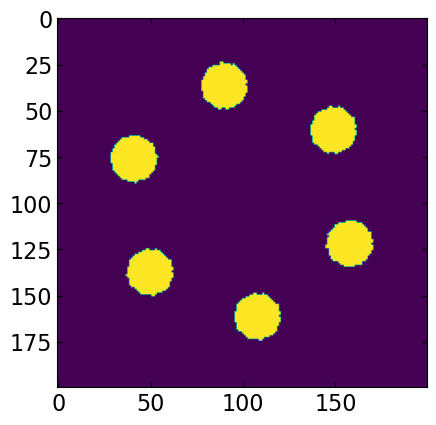

In [45]:
plt.imshow(rotate_mask_up)

# Set new circle with small radius

## Generate base and recorrect the mask region and decrease the mask region

In [46]:
def upsample_mask(mask_list,input_size, up_size):
    
    if mask_list[0].shape[-1]==up_size:
        return mask_list
    
    mask_with_inp = []
    for mask_ in mask_list:
        temp_mask = torch.tensor(mask_.reshape(1,1,input_size,input_size),dtype=torch.float)
        temp_mask = F.interpolate(temp_mask, size=(up_size,up_size),mode = 'bicubic')
        temp_mask[temp_mask<0.5]=0
        temp_mask[temp_mask>=0.5]=1
        temp_mask = torch.tensor(temp_mask.squeeze(),dtype=torch.bool)
        mask_with_inp.append(temp_mask)

    return mask_with_inp

In [47]:
def center_mask_list_function(image,mask_list,coef,radius=7):
    
    center_mask_list = []
    mean_ = np.zeros([image.shape[-2],image.shape[-1]])
    
    input_size = mask_list[0].shape[-1]
    up_size = image.shape[-1]
    
    if input_size!=up_size:
        
        mask_list = upsample_mask(mask_list,input_size,up_size)
    
    for j, mask in enumerate(mask_list):
        

        mask_ = mask.reshape(1,1,mask.shape[-2],mask.shape[-1])

        new_image = image*mask_

        center_x,center_y = center_of_mass(new_image.squeeze(),mask_.squeeze(),coef)
        
        center_x = int(np.round(np.array(center_x)))
        center_y = int(np.round(np.array(center_y)))
        print(center_x,center_y)
        
        small_mask = mask_function(mean_,radius=radius,center_coordinates=(center_y,center_x))
        
        small_mask = torch.tensor(small_mask,dtype = torch.bool)
        
        center_mask_list.append(small_mask)
        
    if input_size!=up_size:
        
        center_mask_list = upsample_mask(center_mask_list,up_size,input_size)
        
    rotate_mask_up = torch.clone(center_mask_list[0])
    
    for i in range(1,len(center_mask_list)):
        rotate_mask_up+=center_mask_list[i]
        
    return center_mask_list,rotate_mask_up

## Parameters for second Training Process

In [48]:
num_mask_2 = 6
fixed_mask_2 = modified_mask_list_2
interpolate_2 = True

## Model for second process training

In [49]:
def make_model_2(device,
               en_original_step_size = en_original_step_size, 
               pool_list = pool_list, 
               de_original_step_size = de_original_step_size,
               up_list = up_list,
               embedding_size = embedding_size,
               conv_size = conv_size,
               num_basis = num_basis,
               num_mask = num_mask_2,
               fixed_mask = fixed_mask_2,
               learning_rate = 3e-5,
               interpolate = interpolate_2,
               up_size = up_size
               ):
    
    encoder = Encoder(original_step_size=en_original_step_size,
                      pool_list=pool_list,
                      embedding_size=embedding_size,
                      conv_size=conv_size,
                      device = device,
                      num_basis=num_basis,
                      fixed_mask = fixed_mask,
                      num_mask=num_mask,
                      interpolate = interpolate,
                      up_size = up_size).to(device)
    decoder = Decoder(original_step_size=de_original_step_size,
                      up_list=up_list,
                      embedding_size=embedding_size,
                      conv_size=conv_size,
                      device = device,
                      num_basis=num_basis).to(device)
    join = Joint(encoder,decoder,device).to(device)
    
    optimizer = optim.Adam(join.parameters(), lr=learning_rate)
    
    join = torch.nn.parallel.DataParallel(join)
    
    return encoder, decoder, join, optimizer

In [55]:
data_dir

'/scratch/shuyu/Simulated_4dstem_folder/Extremely_Noisy_4DSTEM_Strain_Mapping_Using_CC_ST_AE_Simulated/polycrystal_output4D.mat'

In [56]:
whole_data_with_rotation = load_data_4_process2(data_dir,new_rotation,w_bg=0.25)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 65536/65536 [00:00<00:00, 371607.28it/s]


In [57]:
encoder, decoder, join, optimizer = make_model_2(device,learning_rate = 3e-5)

# can download the weight from: https://zenodo.org/records/10934269

In [58]:
path_checkpoint = "25percent_noisy_simulated_4dstem_pretrained_weights.pkl" 
checkpoint = torch.load(path_checkpoint)  

join.load_state_dict(checkpoint['net'])
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
optimizer.load_state_dict(checkpoint['optimizer'])  
start_epoch = checkpoint['epoch']
start_coef = checkpoint['mse_loss']

In [59]:
#train_iterator = torch.utils.data.DataLoader(bad_list, batch_size = 32,shuffle = True)

In [60]:
train_iterator = torch.utils.data.DataLoader(whole_data_with_rotation, batch_size = 12,shuffle = True)

In [61]:
sample,rot = next(iter(train_iterator))

In [62]:
predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list,x_inp = join(sample.to(device, dtype=torch.float),
                                                                                         rot.to(device, dtype=torch.float))

In [70]:
def adj_img(img,mask_list,adj_vector):
    xs,ys = img.shape
    copy_img = np.copy(img.numpy().reshape(-1))
    for i,mask_ in enumerate(mask_list):
        index = np.argwhere(mask_.reshape(-1)==1)
        copy_img[index] = copy_img[index]*adj_vector.numpy()
    return copy_img.reshape(xs,ys)

def adj_rever_mask(k,img,new_list,adj_vector):
    xs,ys = img.shape
    copy_img = np.copy(img.numpy().reshape(-1))
    
    new_mask = np.zeros([xs,ys],dtype=bool)
    for i,mask_ in enumerate(new_list):
        mask_k = np.array(mask_[k].cpu())

        new_mask+=mask_k
        index = np.argwhere(mask_k.reshape(-1)==1)
        copy_img[index] = copy_img[index]*adj_vector.numpy()
        
#     plt.figure()

#     plt.imshow(new_mask)
    copy_img = copy_img.reshape(xs,ys)
    copy_img[~new_mask]=0
    return copy_img

tensor([[ 0.9658, -0.2592,  0.0000],
        [ 0.2592,  0.9658,  0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[ 1.0098, -0.0202,  0.0000],
        [-0.0202,  1.0092,  0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([1.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.7909, -0.6120,  0.0000],
        [ 0.6120,  0.7909,  0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[0.9873, 0.0014, 0.0000],
        [0.0014, 1.0073, 0.0000]], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.8377, -0.5461,  0.0000],
        [ 0.5461,  0.8377,  0.0000]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[1.0104, 0.0213, 0.0000],
        [0.0213, 1.0096, 0.0000]], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([1.], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 0.9343, -0.3565,  0.0000],
        [ 0.3565,  0.9343,  0.0000]], device='cuda:0',
       

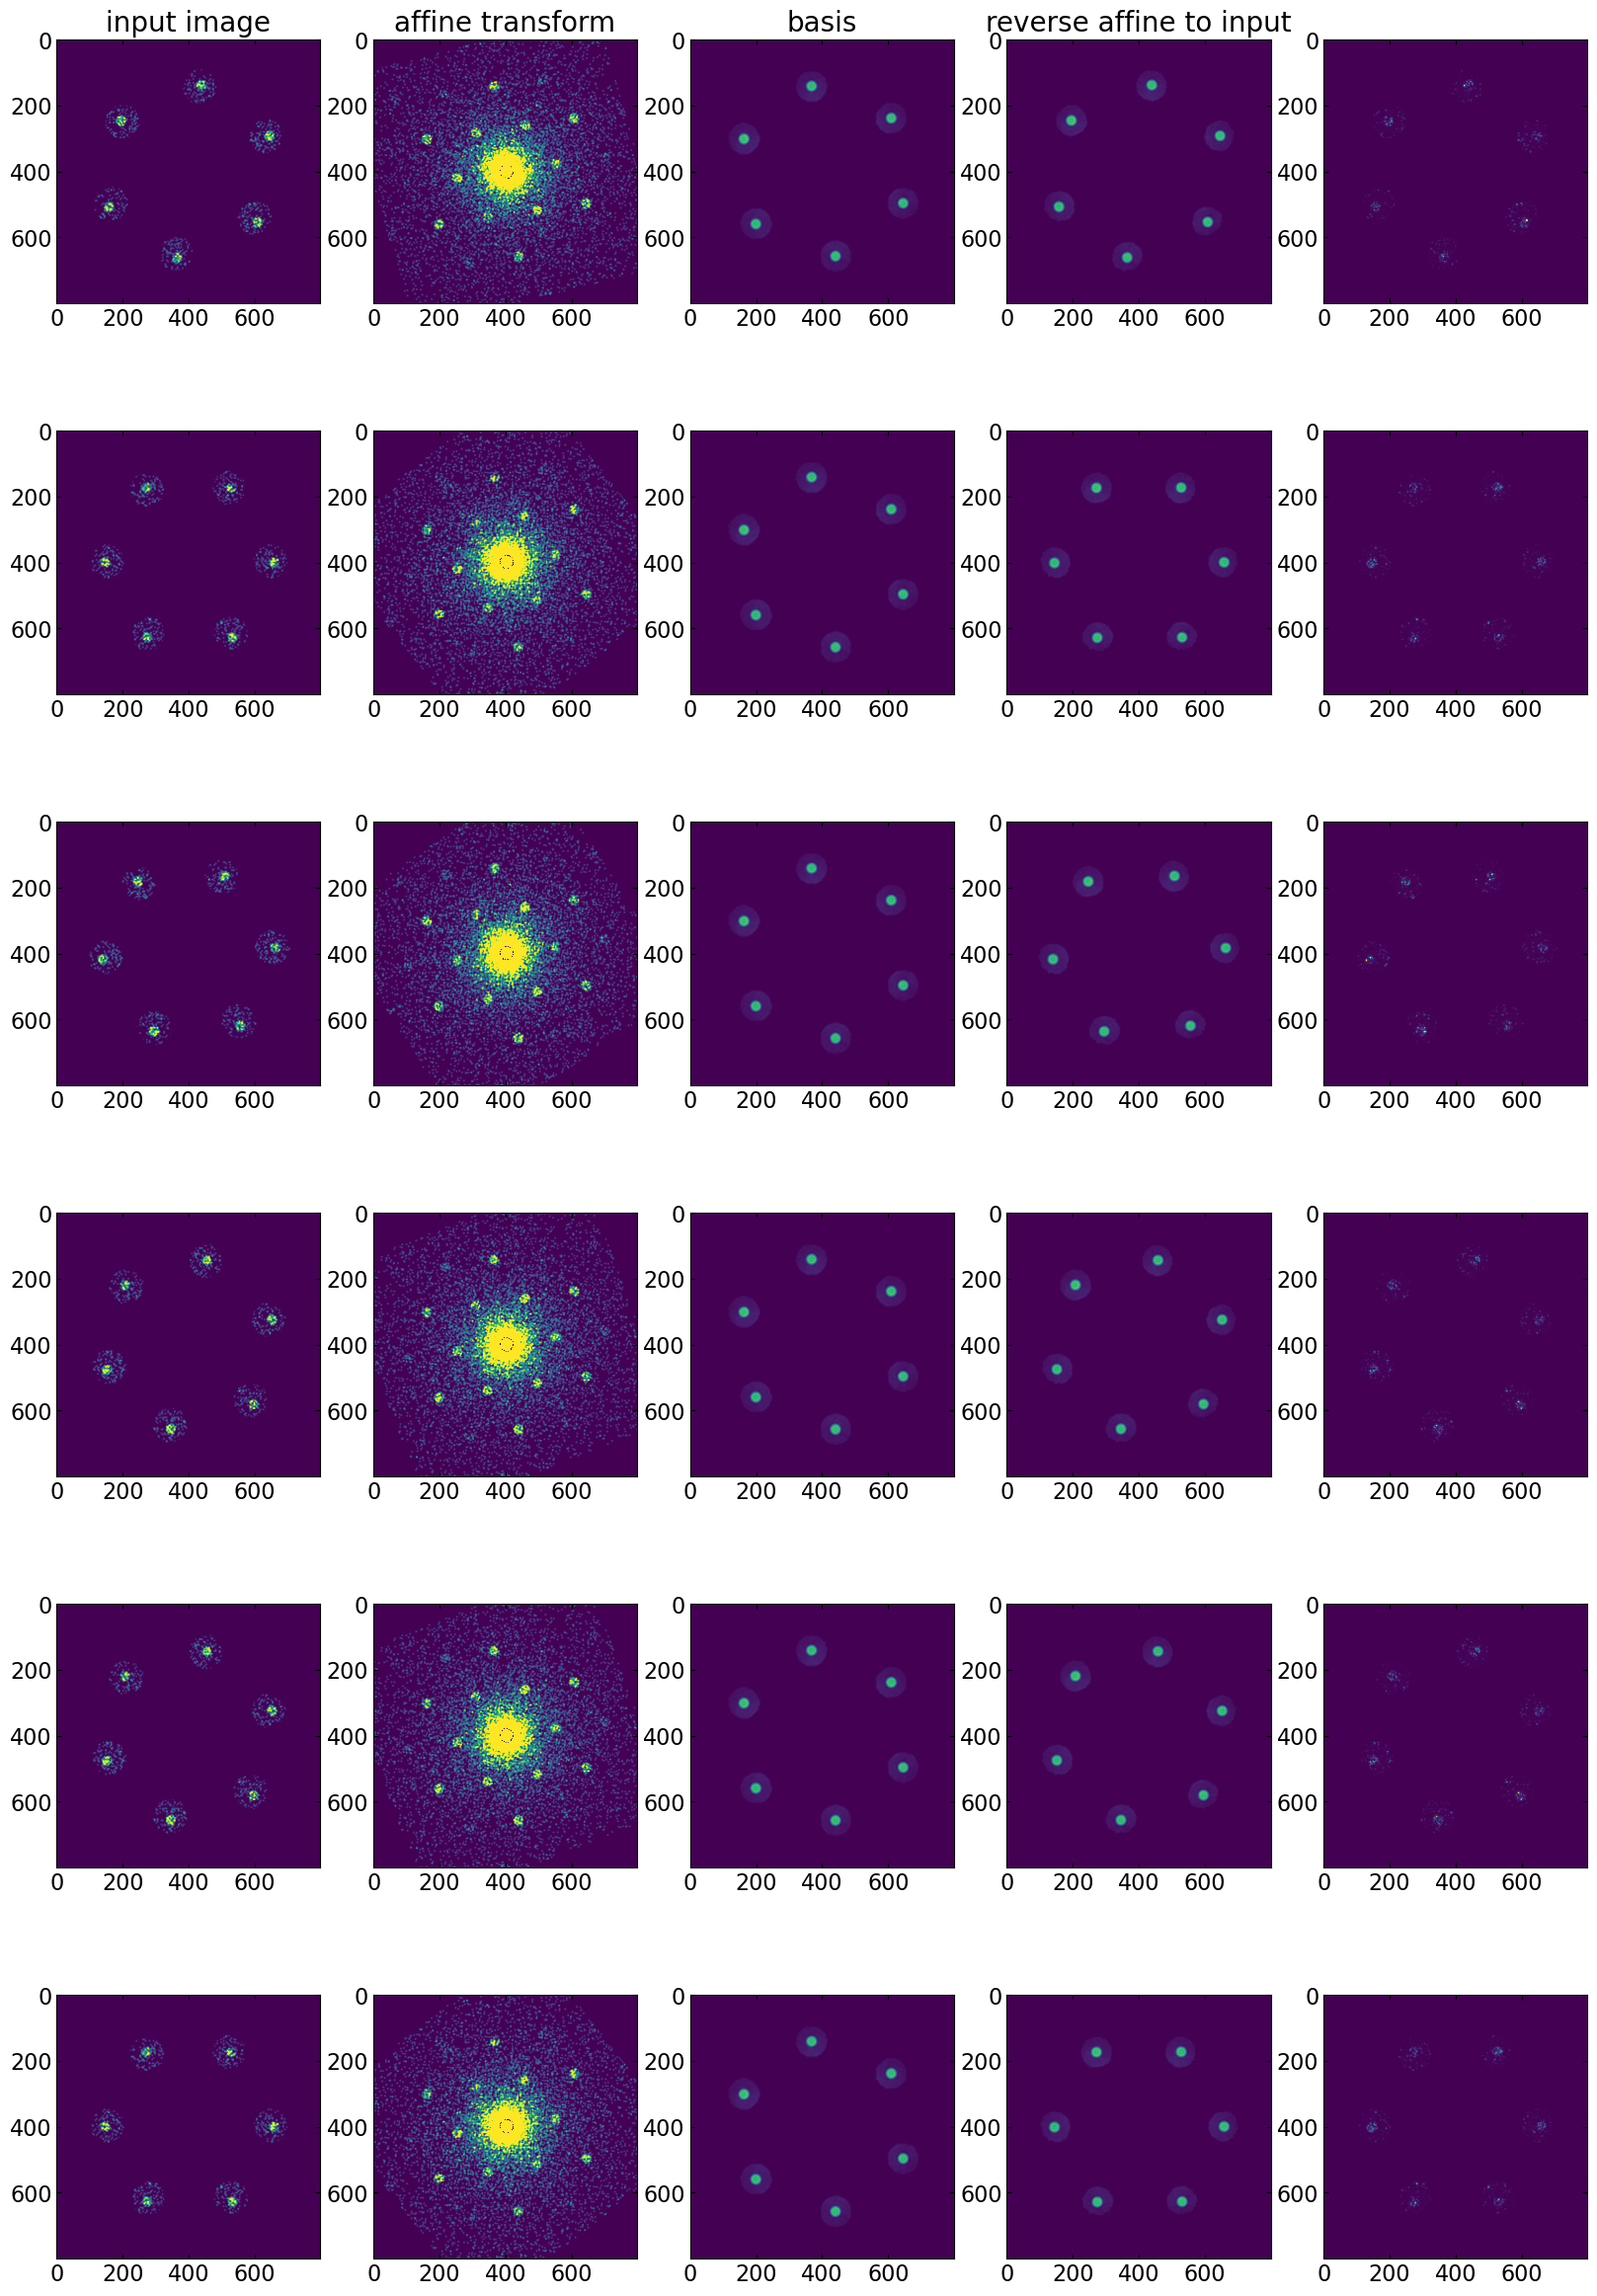

In [71]:
# Visualize the result
mask_scale=True
fig,ax = plt.subplots(6,5,figsize=(20,30))
for i in range(6):
    j = np.random.randint(0,12)
    #i = 247
    if i==0:
        ax[i][0].title.set_text('input image')
        ax[i][1].title.set_text('affine transform')
        ax[i][2].title.set_text('basis')
        ax[i][3].title.set_text('reverse affine to input')
        
#    sample_inp = sample[j].reshape(1,1,sample[0].shape[-1],sample[0].shape[-2])
#    sample_inp = F.interpolate(sample_inp, size=(800,800),mode = 'bicubic')
    adj_vector = adj_mask[j].detach().cpu()
    x_inp_j = x_inp[j].squeeze().detach().cpu()
    sample_mask = adj_rever_mask(j,x_inp_j,new_list,adj_vector)
    
    ax[i][0].imshow(sample_mask.squeeze(),clim=[0,1])
    
    
    predicted_mask = predicted_x[j].squeeze().detach().cpu()
#    predicted_mask[~rotate_center]=0
    ax[i][1].imshow(predicted_mask,clim=[0,1])
    
#    ax[i][1].imshow(predicted_x[j].squeeze().detach().cpu())
    
    #ax[2].imshow((card_small.squeeze()-out[i].squeeze().detach().cpu())**2)
    #num = torch.argmax(prob[i])
     
    ## recreate the base according to the adjust scale mask
    
    recreate_base = predicted_base[j].squeeze().detach().cpu()
    if mask_scale:
        adj_vector = adj_mask[j].detach().cpu()
#        adj_base = adj_img(recreate_base,center_mask_list,adj_vector) 
#        adj_base[~rotate_center]=0   
        ax[i][2].imshow(recreate_base,clim=[0,1])
    else:
        ax[i][2].imshow(recreate_base,clim=[0,1])
 #   recreate_base[~new_mask]=0
    
    
    rever_base = predicted_input[j].squeeze().detach().cpu()
    if mask_scale:
        rever_base = adj_rever_mask(j,rever_base,new_list,adj_vector)
        ax[i][3].imshow(rever_base,clim=[0,1])
        
    else:
        
        ax[i][3].imshow(rever_base,clim=[0,1])
    
#     sample_squeeze = np.copy(sample[j].squeeze())
#     sample_squeeze[~rotate_center] = 0
    
#     if mask_scale:
#         ax[i][4].imshow((predicted_mask-recreate_base)**2,clim=[0,0.1])
#     else:
    ax[i][4].imshow((sample_mask.squeeze()-rever_base)**2,clim=[0,1])
    #ax[3].imshow((label_[num].squeeze()-out[i].squeeze().detach().cpu())**2)
#    print(kout[j])
    print(theta_2[j])
    print(theta_1[j])
    print(adj_mask[j])

In [80]:
# batch_size = 128
# train_iterator = torch.utils.data.DataLoader(whole_data_with_rotation, batch_size = batch_size,shuffle = False)

In [79]:
# rotation_ = np.zeros([65536,2])
# scale_shear_ = np.zeros([65536,4])

# for i, x in enumerate(tqdm(train_iterator,leave=True,total=len(train_iterator))):
#     with torch.no_grad():
#         value,rot = x
#         rot = Variable(rot.cuda()).float()
#         test_value = Variable(value.cuda())
#         test_value = test_value.float()
#         predicted_x,predicted_base,predicted_input,kout,theta_1,theta_2,adj_mask,new_list= join(test_value.to(device, dtype=torch.float),
#                                                                                        rot.to(device, dtype=torch.float))
        
        
#         rotation_[i*batch_size:(i+1)*batch_size] = theta_2[:,:,0].cpu().detach().numpy()

#         scale_shear_[i*batch_size:(i+1)*batch_size] = theta_1[:,:,0:2].cpu().detach().numpy().reshape(-1,4)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [17:49<00:00,  2.09s/it]
